# Model evaluation notebook

in this notebook we will evaluate % availability. definitions are:

X = hour, dow, weekend, holiday, is_sunny, caiso, site_id
y = % available (for site)

this will work for all sites.

How will we do train test split?
random 80-20 for now 


In [1]:
import os
os.chdir('..')
os.getcwd()

'/home/denny/Documents/mids/ev_charging'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from src.data_preprocessing import  datetime_processing, userinput_processing, holiday_processing, create_all_site_x, create_all_site_y, create_x, update_varuns_x, get_start_end_times

In [3]:
df_c = pd.read_parquet('data/sessions/caltech/').reset_index(drop=True)
df_c = datetime_processing(df_c)
df_c = userinput_processing(df_c)
df_c = holiday_processing(df_c)


df_j = pd.read_parquet('data/sessions/jpl/').reset_index(drop=True)
df_j = datetime_processing(df_j)
df_j = userinput_processing(df_j)
df_j = holiday_processing(df_j)

df_o = pd.read_parquet('data/sessions/office001/').reset_index(drop=True)
df_o = datetime_processing(df_o)
df_o = userinput_processing(df_o)
df_o = holiday_processing(df_o)

cols = list(df_c.columns)
df = pd.concat([df_c[cols], df_j[cols], df_o[cols]], axis=0)

In [4]:
print(f'df is a dataframe comprised of these site ids: {list(df.siteID.unique())}')

df is a dataframe comprised of these site ids: [2, 1, 19]


# Make X and y

In [5]:
start = '2018-05-01'
end = '2021-09-13'
spaceID = 'CA-303'
caiso_fp = 'data/caiso_dataset_5min.csv'
sun_fp = 'data/ct_sr_ss.csv'

In [11]:
X = pd.DataFrame()
sites_df = [df_o,df_c,df_j]
site_ids = [2,1,19]
caiso_fp = 'data/caiso_dataset_5min.csv'


for sdf, id, sun_fp in zip(sites_df, site_ids, ['data/of_sr_ss.csv','data/ct_sr_ss.csv', 'data/jpl_sr_ss.csv'] ):
    start, end = get_start_end_times(sdf)
    tmpx = create_x(start, end, caiso_fp, sun_fp)
    tmpx = update_varuns_x(tmpx, id)
    
    if X.empty:
        X = tmpx
    else:
        X = pd.concat([X, tmpx], axis=0)
    

/home/denny/Documents/mids/ev_charging/src/data_preprocessing.py:183: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sun['sunset_ts'] = pd.to_datetime(sun['date'] + ' ' + sun['sunset'], errors='coerce', utc=True)
/home/denny/Documents/mids/ev_charging/src/data_preprocessing.py:183: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sun['sunset_ts'] = pd.to_datetime(sun['date'] + ' ' + sun['sunset'], errors='coerce', utc=True)
/home/denny/Documents/mids/ev_charging/src/data_preprocessing.py:183: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sun['sunset_ts'] = pd.to_datetime(sun['d

In [18]:
X['siteID'].value_counts().sum() == X.shape[0]
print(f'there are {X.shape[0]} records')

there are 77715 records


# Deal with covid
we found (graphically) that covid effects start around march 3rd 2020, so we truncated our data to march 1st. Since we did not have dates that contained post covid data, we did not include any charges after 2020-03-01 

In [19]:
x = X[X.index < '2020-03-01']
x.index.max()


Timestamp('2020-02-29 23:00:00+0000', tz='UTC')

In [20]:
cols = list(df_c.columns)
df = pd.concat([df[cols] for df in sites_df], axis=0)
y = create_all_site_y(df, regression=True)

In [21]:
assert X.shape[0] == y.shape[0], 'X and y rows are not equal!'

In [22]:
y = y[y.index < '2020-03-01']
y.index.max()

Timestamp('2020-02-29 23:00:00+0000', tz='UTC')

In [23]:
assert x.shape[0] == y.shape[0], 'forgot to trim y\'s covid!'

In [24]:
y.shape

(37320,)

In [25]:
x.shape

(37320, 30)

# Modeling
In this section we will compare 

- linear regression models
- XGBoost regression, and 
- LSTM

models using the evaluation metric of RMSE

## LR

In [29]:
x = x.drop(columns='connectionTime')

In [31]:
x.columns
cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]
x[cat_cols]

,dow,hour,month,is_sunny,is_holiday,siteID
2019-03-25 00:00:00+00:00,0,0,3,0,False,2
2019-03-25 01:00:00+00:00,0,1,3,0,False,2
2019-03-25 02:00:00+00:00,0,2,3,0,False,2
2019-03-25 03:00:00+00:00,0,3,3,0,False,2
2019-03-25 04:00:00+00:00,0,4,3,0,False,2
...,...,...,...,...,...,...
2020-02-29 19:00:00+00:00,5,19,2,0,False,19
2020-02-29 20:00:00+00:00,5,20,2,0,False,19
2020-02-29 21:00:00+00:00,5,21,2,0,False,19
2020-02-29 22:00:00+00:00,5,22,2,0,False,19


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')


regression_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('lr', LinearRegression()),
        ]
)

regression_model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
print(f'training RMSE: {np.sqrt(mean_squared_error(regression_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(regression_model.predict(X_test), y_test))}')
print(f'training R2: {regression_model.score(X_train, y_train)}\ntest R2    : {regression_model.score(X_test, y_test)}')

training RMSE: 0.19239971305918047
test RMSE    : 0.1932816389082605
training R2: 0.5344652174765449
test R2    : 0.5456558288126412


Text(0, 0.5, '% available')

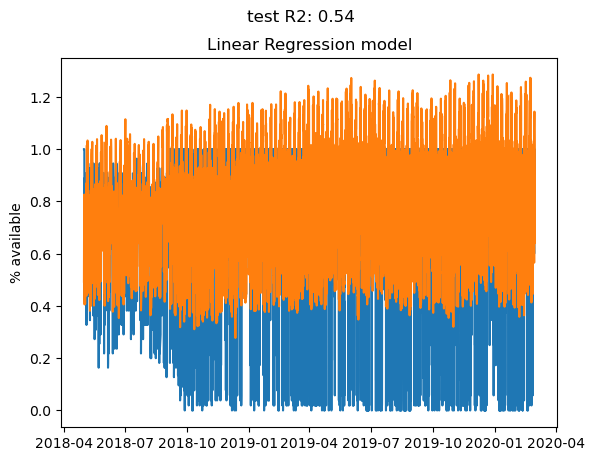

In [40]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
pred = pd.Series(regression_model.predict(X_test), index=X_test.index)
plt.title('Linear Regression model')
plt.suptitle(f'test R2: {np.round(regression_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')

# XGBoost

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')


regression_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('xgb', XGBRegressor()),
        ]
)

regression_model.fit(X_train, y_train)
print(f'training RMSE: {np.sqrt(mean_squared_error(regression_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(regression_model.predict(X_test), y_test))}')
print(f'training loss: {regression_model.score(X_train, y_train)}\ntest loss    : {regression_model.score(X_test, y_test)}')

training RMSE: 0.07627324354614991
test RMSE    : 0.0944032957600561
training loss: 0.9278254374810836
test loss    : 0.8855084479986365


Text(0, 0.5, '% available')

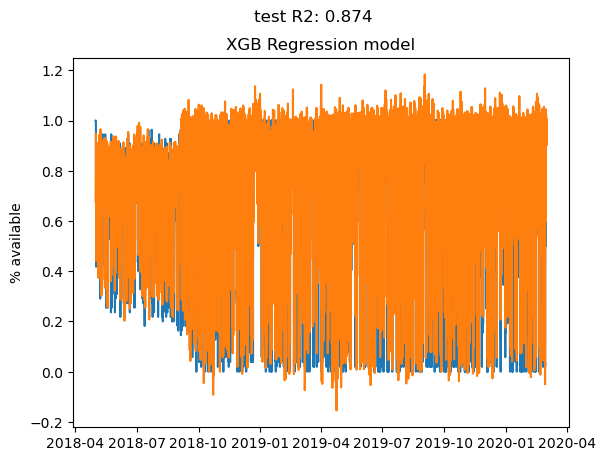

In [42]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
pred = pd.Series(regression_model.predict(X_test), index=X_test.index)
plt.title('XGB Regression model')
plt.suptitle(f'test R2: {np.round(regression_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')